**Author**: Lulof Pirée

**Date**: June 2022

--------------------------------------------------------------------------------
Copyright (C) 2022 Lulof Pirée

This file is part of the snakes_spn program.

This program is free software:
you can redistribute it and/or modify it under the terms
of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.
If not, see <https://www.gnu.org/licenses/>.

--------------------------------------------------------------------------------
## File content
Second pre-study: finding an appropriate rate-constant
for the repression of the inflammation by Gr*,
under the assumption that the repression is strong with maximal Gr*.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy import stats

from spn_case_study.launch_experiment import (
    setup_init_markings_all_choices, setup_rates_all_choices)
from spn_case_study.run_grid_search import run_experiment
from spn_case_study.petrinet import PLACES, VARS, TRANS, TRANS_TO_PLACES
from spn_tools.run_simulation import (plot_results, load_log,
    aggregate_dataset_in_timeboxes)
import numpy as np

SAVEDIR_NAME = "tune_inflam_repress_rate_data"

NUM_REPETITIONS = 1 #200
MAX_NUM_TRANSITIONS = 1500
MAX_TIME_PASSED = 5
# Different constants to try
REPRESSION_RATE_CONSTANTS = [0, 0.0001, 0.01, 1, 100, 1000]
INIT_TOKEN_COUNT = 1000 # One token represents 0.1% of the starting amount.

# Notebooks usually set the cwd to the directory containing the notebook itself.
print(f"Current directory: {os.getcwd()}")
if "tune_inflam_repress_rate.ipynb" in os.listdir(os.getcwd()):
    SAVE_DIR = os.path.join(os.getcwd(), SAVEDIR_NAME)
else:
    raise RuntimeError("Wrong working directory.")

Current directory: /home/nifrec/Vault/Documents/master_1/bio_modelling/model_ass/snakes_spn/spn_case_study


## Experiment
Initially, we set:
* $[Gr*] = [\text{Free Neutrophils}] = [\text{inflammation signals}] = 1000$,
    and 0 for all other places.
* The rate-function for recruiting neutrophils is simply given
    as $f() = [\text{Free Neutrophils}] \times [\text{inflammation signals}]$.


In [2]:
def run_tuning_experiment():
    init_markings = setup_markings()
    for rate_const in REPRESSION_RATE_CONSTANTS:
        RATE_AS_DIRNAME = rate_const_to_dirname(rate_const)
        SUBDIR_NAME = os.path.join(SAVE_DIR, RATE_AS_DIRNAME)
        rates = setup_rates(rate_const)

        log_filename = os.path.join(SUBDIR_NAME, "logs.json")
        if not os.path.exists(log_filename):
            run_experiment(rates, init_markings, SUBDIR_NAME, NUM_REPETITIONS, 
                        max_steps=MAX_NUM_TRANSITIONS, max_time=MAX_TIME_PASSED)
        else:
            print("Experiment data already present, skipping experiment.")
    
def rate_const_to_dirname(rate_const: int | float) -> str:
        # Convert the rate to scientific notation, without a '.' or a '+'.
        # Then it is safe to use as a directory name.
        return f"rate_{rate_const:.0e}".replace("+", "")

def setup_markings() -> dict[str, tuple[int]]:
    init_markings = {name: (0,) for name in PLACES}
    init_markings["neutrophil_free"] = (INIT_TOKEN_COUNT,)
    init_markings["infl_sig"] = (INIT_TOKEN_COUNT,)
    init_markings["gr_pdn"] = (INIT_TOKEN_COUNT,)
    return init_markings


def setup_rates(repress_rate_const: float | int) -> dict[str, str]:
    rates = {name : "0" for name in TRANS}
    rates["recruit_neutrophil"] = f"{VARS['infl_sig']} * {VARS['neutrophil_free']}"
    rates["repress_infl"] = f"{repress_rate_const} * {VARS['infl_sig']} * {VARS['gr_pdn']}"
    return rates

run_tuning_experiment()

Starting repeated experiment with 1 repetitions.
Finished repetition 1/1
All repetitions completed
Starting repeated experiment with 1 repetitions.
Finished repetition 1/1
All repetitions completed
Starting repeated experiment with 1 repetitions.
Finished repetition 1/1
All repetitions completed
Starting repeated experiment with 1 repetitions.
Finished repetition 1/1
All repetitions completed
Starting repeated experiment with 1 repetitions.
Finished repetition 1/1
All repetitions completed
Starting repeated experiment with 1 repetitions.
Finished repetition 1/1
All repetitions completed


[Text(0, 0.5, 'Neutrophil concentration')]

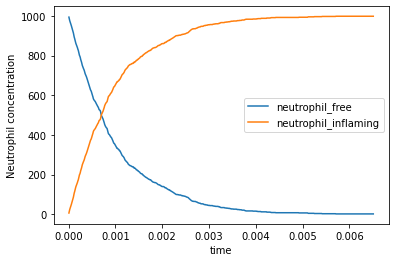

In [3]:
baseline_log = load_log(os.path.join(SAVEDIR_NAME, rate_const_to_dirname(0),
    "logs.json"))
num_timeboxes = MAX_NUM_TRANSITIONS//2
x_var = "time"
y_vars = ["neutrophil_free", "neutrophil_inflaming"]
ax = plot_results(baseline_log, x_var, y_vars, 
             num_timeboxes, interval_type="min_max")
ax.set(ylabel="Neutrophil concentration")